In [1]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, \
    accuracy_score, r2_score, f1_score, root_mean_squared_error, log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LogisticRegression, LinearRegression
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier, RandomForestPlusRegressor
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusMDI
from sklearn.svm import SVC
import shap
from subgroup_detection import *
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=DeprecationWarning)
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy import cluster
from scipy.cluster.hierarchy import fcluster, cut_tree
from joblib import Parallel, delayed

In [2]:
# get abalone data
X, y, feature_names = get_clean_dataset("diabetes_regr", data_source='imodels')
task = 'regression'
data_type = "test"
# convert y to float
y = y.astype(float)

fetching diabetes from sklearn


In [3]:
# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=3)
if data_type == "test":
    X_data = X_test
    y_data = y_test
else:
    X_data = X_train
    y_data = y_train

In [4]:
# fit rf
if task == 'classification':
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42)
else:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)

# fit rf+
if task == 'classification':
    rf_plus = RandomForestPlusClassifier(rf_model = rf, prediction_model = LogisticRegressionCV())
else:
    rf_plus = RandomForestPlusRegressor(rf_model = rf, prediction_model = RidgeCV())
rf_plus.fit(X_train, y_train)

# fit baseline model
if task == "classification":
    rf_plus_baseline = RandomForestPlusClassifier(rf_model=rf, include_raw=False, fit_on="inbag", prediction_model=LogisticRegression())
elif task == "regression":
    rf_plus_baseline = RandomForestPlusRegressor(rf_model=rf, include_raw=False, fit_on="inbag", prediction_model=LinearRegression())
rf_plus_baseline.fit(X_train, y_train)

# check performance on test set
y_pred_rf_plus = rf_plus.predict(X_test)

# accuracy
if task == 'classification':
    accuracy_rf_plus = accuracy_score(y_test, y_pred_rf_plus)
else:
    r2_rf_plus = r2_score(y_test, y_pred_rf_plus)

if task == 'classification':
    print(f'RF+ Test Set Accuracy: {accuracy_rf_plus}')
else:
    print(f'RF+ Test Set R^2: {r2_rf_plus}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


RF+ Test Set R^2: 0.4274633423340176


In [5]:
# # get feature importances
# mdi_explainer = RFPlusMDI(rf_plus)
# mdi = mdi_explainer.explain_linear_partial(np.asarray(X_train), y_train, l2norm = True, sign = True, leaf_average=True)
# if data_type == "test":
#     mdi = mdi_explainer.explain_linear_partial(np.asarray(X_test), l2norm = True, sign = True, leaf_average=True)
# mdi_rankings = mdi_explainer.get_rankings(mdi)

In [6]:
def get_lmdi(X, y, lmdi_explainer, l2norm, sign, normalize, leaf_average):
    # get feature importances
    lmdi = lmdi_explainer.explain_linear_partial(X, y, l2norm=l2norm, sign=sign,
                                                 normalize=normalize,
                                                 leaf_average=leaf_average)
    mdi_rankings = lmdi_explainer.get_rankings(np.abs(lmdi))
    return lmdi, mdi_rankings

In [7]:
def get_shap(X, shap_explainer):
    if task == "classification":
        # the shap values are an array of shape
        # (# of samples, # of features, # of classes), and in this binary
        # classification case, we want the shap values for the positive class.
        # check_additivity=False is used to speed up computation.
        shap_values = \
            shap_explainer.shap_values(X, check_additivity=False)[:, :, 1]
    else:
        # check_additivity=False is used to speed up computation.
        shap_values = shap_explainer.shap_values(X, check_additivity=False)
    # get the rankings of the shap values. negative absolute value is taken
    # because np.argsort sorts from smallest to largest.
    shap_rankings = np.argsort(-np.abs(shap_values), axis = 1)
    return shap_values, shap_rankings

In [8]:
# obtain shap feature importances
shap_explainer = shap.TreeExplainer(rf)
if data_type == "test":
    shap_values, shap_rankings = get_shap(X_test, shap_explainer)
else:
    shap_values, shap_rankings = get_shap(X_train, shap_explainer)

In [9]:
# obtain lmdi feature importances
lmdi_explainer = RFPlusMDI(rf_plus)
lmdi_baseline_explainer = RFPlusMDI(rf_plus_baseline, mode = "only_k", evaluate_on = "inbag")
lmdi_values_signed_normalized_l2_avg, \
    lmdi_rankings_signed_normalized_l2_avg = \
        get_lmdi(X_train, y_train, lmdi_explainer, l2norm=True, sign=True,
                    normalize=True, leaf_average=True)
lmdi_values_signed_normalized_l2_noavg, \
    lmdi_rankings_signed_normalized_l2_noavg = \
        get_lmdi(X_train, y_train, lmdi_explainer, l2norm=True, sign=True,
                    normalize=True, leaf_average=False)
lmdi_values_signed_nonnormalized_l2_avg, \
    lmdi_rankings_signed_nonnormalized_l2_avg = \
        get_lmdi(X_train, y_train, lmdi_explainer, l2norm=True, sign=True,
                    normalize=False, leaf_average=True)
lmdi_values_signed_nonnormalized_l2_noavg, \
    lmdi_rankings_signed_nonnormalized_l2_noavg = \
        get_lmdi(X_train, y_train, lmdi_explainer, l2norm=True, sign=True,
                    normalize=False, leaf_average=False)
lmdi_values_nonl2_avg, lmdi_rankings_nonl2_avg = \
    get_lmdi(X_train, y_train, lmdi_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=True)
lmdi_values_nonl2_noavg, lmdi_rankings_nonl2_noavg = \
    get_lmdi(X_train, y_train, lmdi_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=False)
lmdi_values_baseline, lmdi_rankings_baseline = \
    get_lmdi(X_train, y_train, lmdi_baseline_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=False)
if data_type == "test":
    lmdi_values_signed_normalized_l2_avg, \
        lmdi_rankings_signed_normalized_l2_avg = \
            get_lmdi(X_test, None, lmdi_explainer, l2norm=True, sign=True,
                    normalize=True, leaf_average=True)
    lmdi_values_signed_normalized_l2_noavg, \
        lmdi_rankings_signed_normalized_l2_noavg = \
            get_lmdi(X_test, None, lmdi_explainer, l2norm=True, sign=True,
                    normalize=True, leaf_average=False)
    lmdi_values_signed_nonnormalized_l2_avg, \
        lmdi_rankings_signed_nonnormalized_l2_avg = \
            get_lmdi(X_test, None, lmdi_explainer, l2norm=True, sign=True,
                    normalize=False, leaf_average=True)
    lmdi_values_signed_nonnormalized_l2_noavg, \
        lmdi_rankings_signed_nonnormalized_l2_noavg = \
            get_lmdi(X_test, None, lmdi_explainer, l2norm=True, sign=True,
                    normalize=False, leaf_average=False)
    lmdi_values_nonl2_avg, lmdi_rankings_nonl2_avg = \
        get_lmdi(X_test, None, lmdi_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=True)
    lmdi_values_nonl2_noavg, lmdi_rankings_nonl2_noavg = \
        get_lmdi(X_test, None, lmdi_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=False)
    lmdi_values_baseline, lmdi_rankings_baseline = \
        get_lmdi(X_test, None, lmdi_baseline_explainer, l2norm=False, sign=False,
                normalize=False, leaf_average=False)

In [10]:
# create storage for iteration purposes
lfi_values = \
    {'shap': shap_values,
        'signed_normalized_l2_avg': lmdi_values_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': lmdi_values_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_values_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_values_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_values_nonl2_avg,
        'nonl2_noavg': lmdi_values_nonl2_noavg,
        'baseline': lmdi_values_baseline}
lfi_rankings = \
    {'shap': shap_rankings,
        'signed_normalized_l2_avg': lmdi_rankings_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': lmdi_rankings_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_rankings_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_rankings_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_rankings_nonl2_avg,
        'nonl2_noavg': lmdi_rankings_nonl2_noavg,
        'baseline': lmdi_rankings_baseline}

In [11]:
def compute_rbo_for_method_and_p(method, ranking, p):
    """
    Helper function to compute the RBO matrix for a given method and p value.
    """
    # print("method:")
    # print(method)
    return (method + "_" + str(p), compute_rbo_matrix(ranking, 'distance', p=p))

# parallelize the computation of RBO matrices
rbo_matrices = dict(Parallel(n_jobs=2)(
    delayed(compute_rbo_for_method_and_p)(method, ranking, p)
    for method, ranking in lfi_rankings.items()
    for p in [0.1, 0.3, 0.5, 0.7, 0.9]
))

In [12]:
# get linkages for values
values_linkage = {}
for method, values in lfi_values.items():
    values_linkage[method] = cluster.hierarchy.ward(values)

# get linkages for rankings
rankings_linkage = {}
for method, rbo_mat in rbo_matrices.items():
    rankings_linkage[method] = cluster.hierarchy.ward(squareform(rbo_mat))

In [23]:
# get clusters for values
value_clusters = {}
for method, link in values_linkage.items():
    # maximum number of clusters is the number of unique feature importances
    max_num_clusters = np.unique(lfi_values[method], axis = 0).shape[0]
    print(f"The Number of Unique Values (Maximum # of Clusters) for {method} is {max_num_clusters}.")
    num_cluster_map = {}
    for num_clusters in np.arange(1, max_num_clusters + 1):
        # num_cluster_map[num_clusters] = fcluster(link, num_clusters,
        #                                             criterion = "maxclust")
        num_cluster_map[num_clusters] = cut_tree(link, n_clusters=num_clusters).flatten()
    value_clusters[method] = num_cluster_map
    
# get clusters for rankings
ranking_clusters = {}
for method, link in rankings_linkage.items():
    # maximum number of clusters is the number of unique rankings
    max_num_clusters = np.unique(rbo_matrices[method], axis = 0).shape[0]
    print(f"The Number of Unique Rankings (Maximum # of Clusters) for {method} is {max_num_clusters}.")
    num_cluster_map = {}
    for num_clusters in np.arange(1, max_num_clusters + 1):
        # num_cluster_map[num_clusters] = fcluster(link, num_clusters,
        #                                             criterion = "maxclust")
        num_cluster_map[num_clusters] = cut_tree(link, n_clusters=num_clusters).flatten()
    ranking_clusters[method] = num_cluster_map


The Number of Unique Values (Maximum # of Clusters) for shap is 133.
The Number of Unique Values (Maximum # of Clusters) for signed_normalized_l2_avg is 133.
The Number of Unique Values (Maximum # of Clusters) for signed_normalized_l2_noavg is 133.
The Number of Unique Values (Maximum # of Clusters) for signed_nonnormalized_l2_avg is 133.
The Number of Unique Values (Maximum # of Clusters) for signed_nonnormalized_l2_noavg is 133.
The Number of Unique Values (Maximum # of Clusters) for nonl2_avg is 133.
The Number of Unique Values (Maximum # of Clusters) for nonl2_noavg is 133.
The Number of Unique Values (Maximum # of Clusters) for baseline is 133.
The Number of Unique Rankings (Maximum # of Clusters) for shap_0.1 is 131.
The Number of Unique Rankings (Maximum # of Clusters) for shap_0.3 is 131.
The Number of Unique Rankings (Maximum # of Clusters) for shap_0.5 is 131.
The Number of Unique Rankings (Maximum # of Clusters) for shap_0.7 is 131.
The Number of Unique Rankings (Maximum # o

In [24]:
# get predictions and performance metrics for each methods clusters
if task == "classification":
    metrics = {"AUROC": roc_auc_score, "AUPRC": average_precision_score,
                "F1": f1_score, "Accuracy": accuracy_score,
                "R^2": r2_score, "Cross-Entropy": log_loss}
elif task == "regression":
    metrics = {"R^2": r2_score, "RMSE": root_mean_squared_error}

In [ ]:
value_clusters

In [30]:
def evaluate_method(method, cluster_map, metrics, y_data):
    metric_results = {}
    max_num_clusters = np.max(list(cluster_map.keys()))
    print("Max Num Clusters:", max_num_clusters)
    metric_results["nclust"] = np.arange(1, max_num_clusters + 1)
    printed = False
    for metric, metric_func in metrics.items():
        cluster_results = np.repeat(np.nan, max_num_clusters)
        for num_clusters, clusters in cluster_map.items():
            if num_clusters == max_num_clusters:
                print("here1")
            cluster_predictions = np.repeat(np.nan, len(clusters))
            cluster_truths = np.repeat(np.nan, len(clusters))
            for i in range(num_clusters):
                if i == max_num_clusters:
                    print("here2")
                    print("clusters:", clusters)
                    print("clusters length:", len(clusters))
                    print("number of unique clusters:", np.unique(clusters).shape[0])
                    print("biggest cluster number:", np.max(clusters))
                cluster_indices = np.where(clusters == i)[0]
                if i == max_num_clusters:
                    print("cluster indices", cluster_indices)
                if y_data[cluster_indices].shape[0] == 0:
                    continue
                cluster_predictions[cluster_indices] = \
                    np.mean(y_data[cluster_indices])
                if metric in ["Accuracy", "F1"]:
                    cluster_predictions[cluster_indices] = \
                        cluster_predictions[cluster_indices] > 0.5
                cluster_truths[cluster_indices] = y_data[cluster_indices]
                if i == max_num_clusters and printed == False:
                    print(method)
                    print(cluster_predictions - cluster_truths)
                    printed = True
            cluster_results[num_clusters-1] = metric_func(cluster_truths,
                                                        cluster_predictions)
        metric_results[metric] = cluster_results
    return method, metric_results

if data_type == "test":
    # method_values_results = dict(Parallel(n_jobs=2)(
    #     delayed(evaluate_method)(method, cluster_map, metrics, y_test)
    #     for method, cluster_map in value_clusters.items()))
    print("here3")
    method_values_results = dict(evaluate_method(method, cluster_map, metrics, y_test) for method, cluster_map in value_clusters.items())
else:
    # method_values_results = dict(Parallel(n_jobs=2)(
    #     delayed(evaluate_method)(method, cluster_map, metrics, y_train)
    #     for method, cluster_map in value_clusters.items()))
    method_values_results = dict(evaluate_method(method, cluster_map, metrics, y_train) for method, cluster_map in value_clusters.items())
# if data_type == "test":
#     method_rankings_results = dict(Parallel(n_jobs=2)(
#         delayed(evaluate_method)(method, cluster_map, metrics, y_test)
#         for method, cluster_map in ranking_clusters.items()))
# else:
#     method_rankings_results = dict(Parallel(n_jobs=2)(
#         delayed(evaluate_method)(method, cluster_map, metrics, y_train)
#         for method, cluster_map in ranking_clusters.items()))

here3
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1
Max Num Clusters: 133
here1
here1


In [31]:
for method in method_values_results.keys():
    print(f"R^2 for {method} at 133 clusters is {method_values_results[method]['R^2'][132]}")

R^2 for shap at 133 clusters is 1.0
R^2 for signed_normalized_l2_avg at 133 clusters is 1.0
R^2 for signed_normalized_l2_noavg at 133 clusters is 1.0
R^2 for signed_nonnormalized_l2_avg at 133 clusters is 1.0
R^2 for signed_nonnormalized_l2_noavg at 133 clusters is 1.0
R^2 for nonl2_avg at 133 clusters is 1.0
R^2 for nonl2_noavg at 133 clusters is 1.0
R^2 for baseline at 133 clusters is 1.0


In [34]:
method_values_results

{'shap': {'nclust': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
          27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
          53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
          66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
         105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
         118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
         131, 132, 133]),
  'R^2': array([0.        , 0.2927174 , 0.31298573, 0.3555322 , 0.40046554,
         0.40537322, 0.41733588, 0.42427932, 0.45783226, 0.47039441,
         0.4760174 , 0.47941986, 0.48391261, 0.48459165, 0.48586485,
  

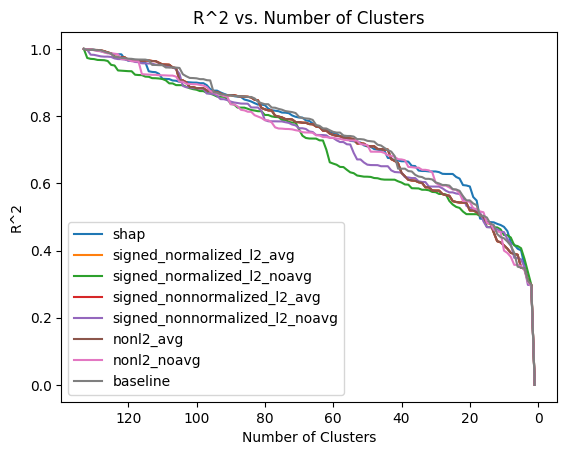

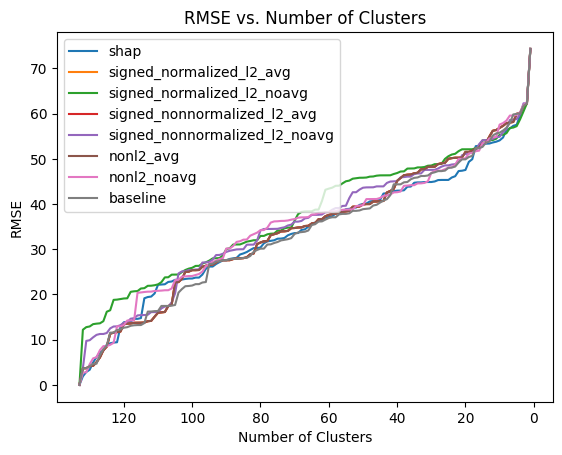

In [37]:
metrics = ["R^2", "RMSE"]
for metric in metrics:
    plt.figure()
    for method, results in method_values_results.items():
        plt.plot(results["nclust"], results[metric], label=method)
    plt.xlabel("Number of Clusters")
    plt.gca().invert_xaxis()
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Number of Clusters")
    plt.legend()
    plt.show()

In [ ]:
task_results = {}
task_results['diabetes_regr'] = 'regression'
for key, values_dict in method_values_results.items():
    if task_results[key] == 'classification':
        metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
    else:
        metrics = ['R^2', 'RMSE']
    # print "Results for " + text of key after first underscore
    parts = key.split('_')
    print(f"Results for dataset {parts[1]} from datasource {parts[0]}.")
    # create new plot
    if task_results[key] == 'classification':
        height = 15
    else:
        height = 5
    fig, axes = plt.subplots(math.ceil(len(metrics)/2.0), 2, figsize=(10, height))
    axes = axes.flatten()
    plot_count = 0
    for metric in metrics:
        ax = axes[plot_count]
        # plt.figure()
        for method, df in values_dict.items():
            # plt.plot(df['nclust'], df[metric])
            ax.plot(df['nclust'], df[metric])
        ax.legend(list(values_dict.keys()))
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Cluster ' + metric)
        ax.set_title('Cluster ' + metric + ' vs Number of Clusters')
        ax.invert_xaxis()
        plot_count += 1
    plt.tight_layout()
    plt.show()